In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


#How to add the file to gdrive

1. Open the drive link shared
2. Click the three dots next to ***HV-AI-2024*** and select 'Make a copy'

In [2]:
!cp /content/drive/MyDrive/HV-AI-2024.zip /content/HV-AI-2024.zip
!unzip HV-AI-2024.zip
!rm -rf /content/__MACOSX
!mv /content/HV-AI-2024/* /content/
!rm -rf /content/HV-AI-2024
!rm /content/HV-AI-2024.zip
!rm -rf /content/sample_data
from google.colab import output
output.clear()


# **Helper Functions**

In [22]:
import requests

def send_results_for_evaluation(name, csv_file, email, college):
    url = "http://43.205.49.236:5050/inference"
    files = {'file': open(csv_file, 'rb')}
    data = {'email': email, 'name':name, 'college':college}
    response = requests.post(url, files=files, data=data)
    return response.json()



# **Plot Sample Images**

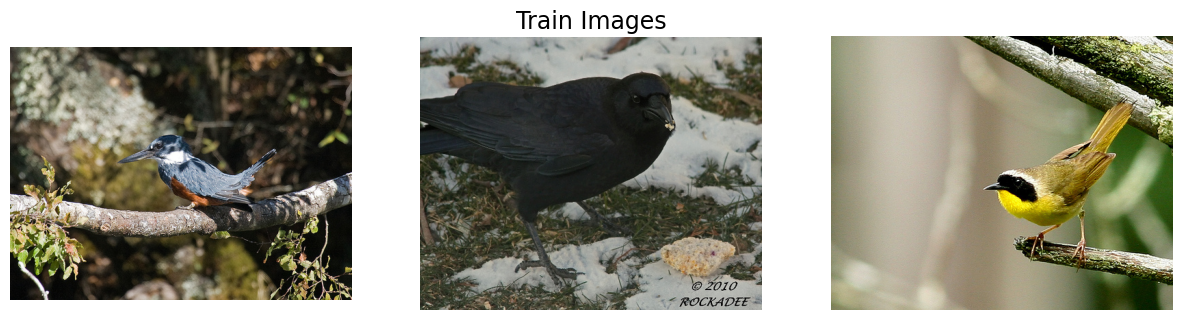

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from glob import glob


train_images = glob('images/train/*.jpg')[0:3]
test_images = glob('images/test/*.jpg')[0:3]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, image in enumerate(train_images):
    img = cv2.imread(image)
    if img is None:
      print(f"Image at {img} cannot be loaded.")
    else:
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      axes[i].imshow(img)
      axes[i].axis('off')

axes[1].set_title('Train Images',fontsize=17)
plt.show()

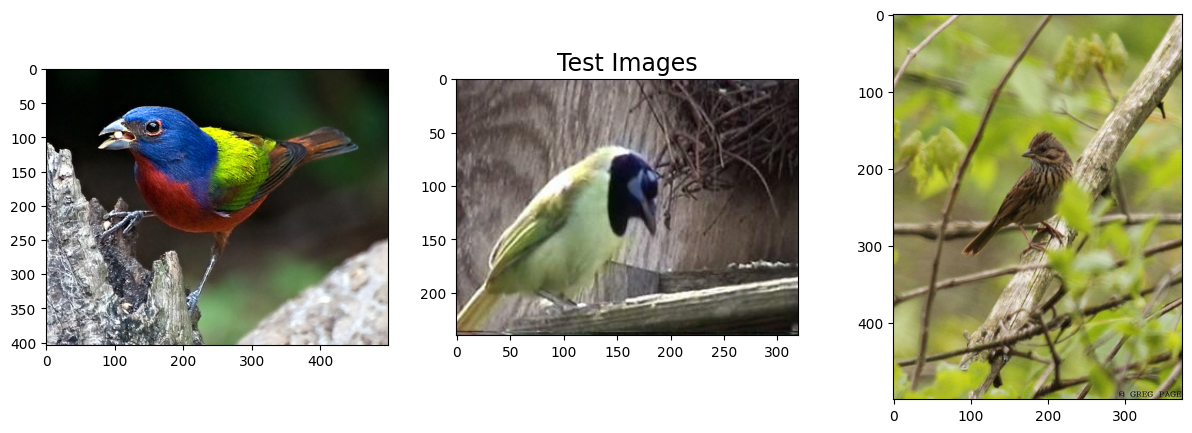

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, image in enumerate(test_images):
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)

axes[1].set_title('Test Images',fontsize=17)
plt.show()

# **Load/Preprocess **data****

In [5]:
!pip install torch torchvision pandas

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from PIL import Image
import os

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [6]:
class BirdDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, use_boxes=False):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.use_boxes = use_boxes

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])

        # Ensure the path is correct
        if not os.path.isfile(img_name):
            raise FileNotFoundError(f"File not found: {img_name}")

        image = Image.open(img_name).convert("RGB")

        label = self.data.iloc[idx, 1]  # Assuming label is in the second column

        if self.use_boxes:
            bbox = self.data.iloc[idx, 2:6].values  # Assuming bounding box coordinates are from the third to sixth columns
            image = image.crop(bbox)  # Crop the image using the bounding box

        if self.transform:
            image = self.transform(image)

        return image, label

In [7]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [8]:
train_csv = '/content/train.csv'
train_dir = '/content/'

test_csv = '/content/test.csv'
test_dir = '/content/'

train_dataset = BirdDataset(csv_file=train_csv, root_dir=train_dir, transform=train_transform, use_boxes=False)
test_dataset = BirdDataset(csv_file=test_csv, root_dir=test_dir, transform=test_transform, use_boxes=False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


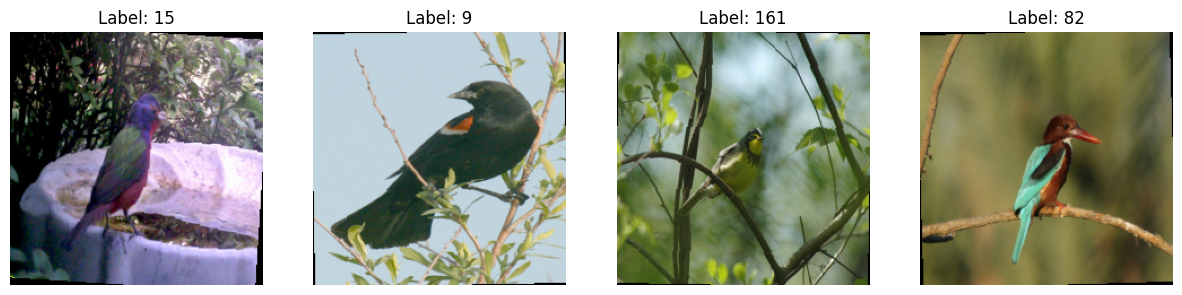

In [9]:
import matplotlib.pyplot as plt

# Get the batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Plot the images
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
  ax = axes[i]
  img = images[i].permute(1, 2, 0).cpu().numpy()
  img = img*[0.229, 0.224, 0.225]+[0.485, 0.456, 0.406]
  ax.imshow(img)
  ax.set_title(f'Label: {labels[i].item()}')
  ax.axis('off')

plt.show()

# **Model initialization/Training**

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score
import pandas as pd
from PIL import Image
import os

# Define transformations for training and validation sets
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Dataset class
class BirdDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, use_boxes=False, is_test=False):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.use_boxes = use_boxes
        self.is_test = is_test

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')

        if self.use_boxes:
            bbox = [float(coord) for coord in self.annotations.iloc[idx, 1].split()] if self.is_test else \
                   [float(coord) for coord in self.annotations.iloc[idx, 2].split()]
            left, top, right, bottom = bbox

            # Ensure bbox coordinates are in the correct order
            if right < left:
                left, right = right, left
            if bottom < top:
                top, bottom = bottom, top

            image = image.crop((left, top, right, bottom))  # Crop image based on bounding box coordinates

        label = int(self.annotations.iloc[idx, 1]) if not self.is_test else None

        if self.transform:
            image = self.transform(image)

        return (image, label) if label is not None else (image, img_name)

# Initialize Datasets and DataLoaders
train_dataset = BirdDataset(csv_file='/content/train.csv',
                            root_dir='/content/',
                            transform=train_transforms,
                            use_boxes=True,
                            is_test=False)

test_dataset = BirdDataset(csv_file='/content/test.csv',
                           root_dir='/content/',
                           transform=test_transforms,
                           use_boxes=True,
                           is_test=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Load a pretrained model and modify the last layer for classification task
model = models.resnet50(weights='DEFAULT')
num_fltrs = model.fc.in_features
model.fc = nn.Linear(num_fltrs, 200)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    print("Training completed")

# Validation loop
def validate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test accuracy: {accuracy:.4f}")

train_model(model, train_loader, criterion, optimizer, num_epochs=10)

Epoch 1/10, Loss: 5.0836
Epoch 2/10, Loss: 4.3901
Epoch 3/10, Loss: 3.8165
Epoch 4/10, Loss: 3.3291
Epoch 5/10, Loss: 2.8720
Epoch 6/10, Loss: 2.5038
Epoch 7/10, Loss: 2.1370
Epoch 8/10, Loss: 1.7935
Epoch 9/10, Loss: 1.4525
Epoch 10/10, Loss: 1.1800
Training completed


# **Model Inference**

In [19]:
def run_inference(model, test_loader):
    model.eval()
    predictions = []

    with torch.no_grad():
        for inputs, img_names in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            confidences = torch.softmax(outputs, dim=1).max(1).values

            for img_name, pred, confidence in zip(img_names, preds, confidences):
                predictions.append({
                    'path': img_name,
                    'predicted_label': pred.item(),
                    'confidence_score': confidence.item()
                })

    return predictions

predictions = run_inference(model, test_loader)

In [20]:
def save_predictions(predictions, output_file='/content/predictions.csv'):
    pred_df = pd.DataFrame(predictions)
    pred_df.to_csv(output_file, index=False)
    print(f"Inference completed and results saved to {output_file}")

In [21]:
save_predictions(predictions)

Inference completed and results saved to /content/predictions.csv


# ***Test Inference***

In [23]:
def test_inference():
    """
    This function is used to save the csv file and send it to the evaluation server.

    Format of CSV file (Follow the header names strictly):

            path (str)              predicted_label(int)   confidence_score(float)
        images/test/xx.jpg                  1                         0.6
        images/test/yy.jpg                  2                         0.9
                :                           :                          :
                :                           :                          :

    Once the prediction file is saved as shown in the above format, you can send it to the evaluation server along with your email.

    Caution: check your **email** before executing the cell.
    Do not change the college name.
    """

    # Perform inference on the test set
    predictions = run_inference(model, test_loader)

    # Save predictions to a CSV file
    output_file = 'pred.csv'
    save_predictions(predictions, output_file=output_file)

    # Send the results for evaluation
    send_results_for_evaluation('Jagadheswaran M', output_file, 'mjagadheswaran@gmail.com', 'Offcampus')

    # Since `send_results_for_evaluation` does not return accuracy, we'll return a placeholder
    return "Inference complete, results sent for evaluation"

# Execute the function
print('Result:', test_inference())


Inference completed and results saved to pred.csv
Result: Inference complete, results sent for evaluation
